In [1]:
import os
import tools
import numpy as np
import pandas as pd
import scanpy as sc

sc.logging.print_header()

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.12.2 python-igraph==0.9.8 pynndescent==0.5.5


In [2]:
os.chdir('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal')

In [7]:
adata = sc.read_h5ad('h5ad/df.fil3_gex_kt.h5ad')
adata

AnnData object with n_obs × n_vars = 916806 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartm

In [4]:
bdata = sc.read_h5ad('h5ad/df.fil3_gex_bcells_no_CLL.h5ad')
bdata

AnnData object with n_obs × n_vars = 70501 × 318
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

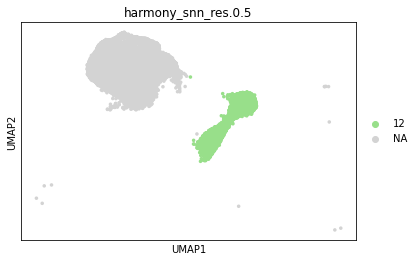

In [8]:
sc.pl.umap(adata[adata.obs['initial_cluster_B'].isin(['B'])], color = ['harmony_snn_res.0.5'], groups = ['12'], size = 50)

In [9]:
df4 = pd.read_csv('../newcastle_covid/datasets/Monaco B cells.txt', sep='\t', header=0, index_col = None, na_filter=False)

In [10]:
def geneset_score(self, genesets, groupby, figsize=(3, 4), cmap = 'viridis', col_cluster = True, row_cluster = True):
    import numpy as np
    import seaborn as sns
    for s in genesets:
        sc.tl.score_genes(self, [y for y in genesets[s] if y != ''], use_raw = True, score_name= str(s)+'_score')
    # calculate average enrichment score
    list1 = list(set(self.obs[groupby]))
    subset = self.obs[[groupby] + [str(s)+'_score' for s in genesets]]
    output = pd.DataFrame()
    for x in list1:
        subsetX = subset[subset[groupby] == x]
        outdict = {}
        for k in [str(s)+'_score' for s in genesets]:
            out = {k:np.mean(subsetX[k])}
            outdict.update(out)
        output = output.append(outdict, ignore_index=True)
    output.index = list1
    output = output[[str(s)+'_score' for s in genesets]]
    g = sns.clustermap(output.transpose(), standard_scale = 0, cmap=cmap, figsize=figsize, col_cluster = col_cluster, row_cluster = row_cluster)
    sc.pl.umap(self, color = [str(s)+'_score' for s in genesets], size = 10, ncols = 2)
    print(g)

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:175: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[score_name] = pd.Series(


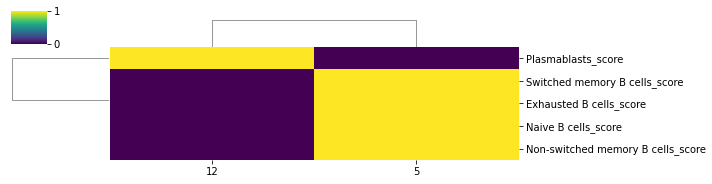

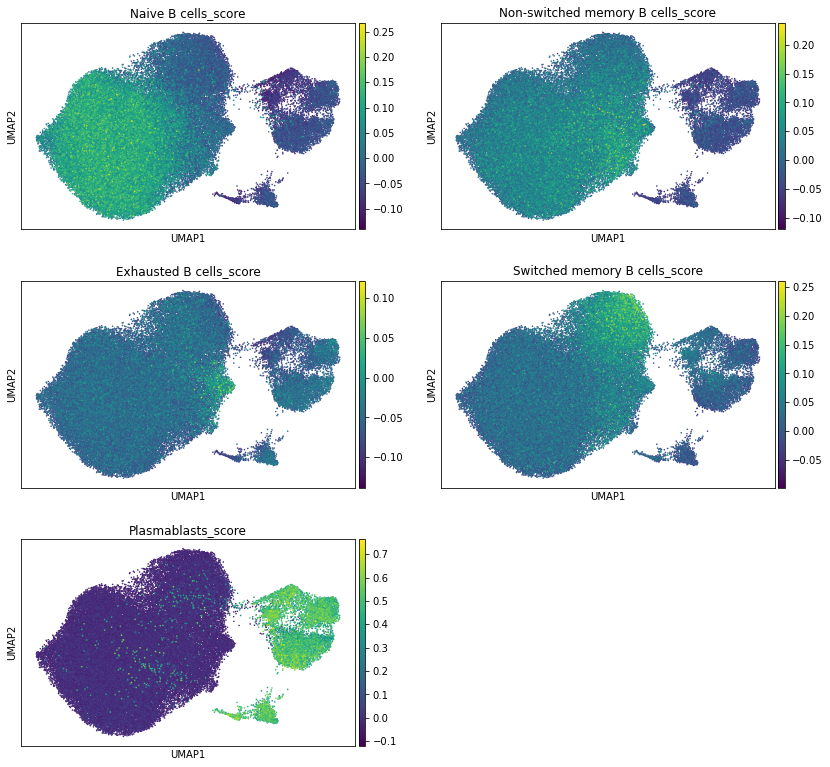

In [11]:
geneset_score(bdata, df4, 'harmony_snn_res.0.5', (10,2.5))

/tmp/ipykernel_6190/2193523879.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  bdata.obs['gmm_pct_b_scores'] = gmm.fit(X).predict(X)


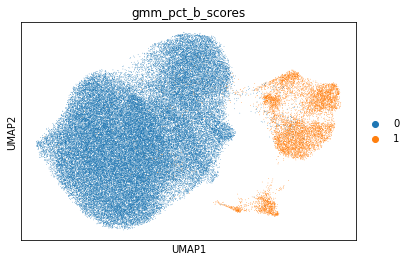

In [12]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=2, max_iter=1000, covariance_type='full')
X = bdata.obs[['Naive B cells_score', 'Non-switched memory B cells_score', 'Exhausted B cells_score', 'Switched memory B cells_score', 'Plasmablasts_score']]
bdata.obs['gmm_pct_b_scores'] = gmm.fit(X).predict(X)
bdata.obs['gmm_pct_b_scores'] = bdata.obs['gmm_pct_b_scores'].astype('category')
sc.pl.umap(bdata, color = 'gmm_pct_b_scores')

In [13]:
# read in the BCR files
sampleinfo = pd.read_csv('processed/BCR/bcr_meta.csv')
sampleinfo

sample   individual
0    C101  C101_tigger
1    C103  C103_tigger
2    C104  C104_tigger
3    C106  C106_tigger
4    C108  C108_tigger
..    ...          ...
58    C69   C69_tigger
59    C73   C73_tigger
60    C82   C82_tigger
61    C85   C85_tigger
62    C93   C93_tigger

[63 rows x 2 columns]

In [14]:
samples = sampleinfo['sample']
bcr_files = []
for sample in samples:
    filelocation = 'processed/BCR/'+ sample +'/dandelion/all_contig_igblast_db-pass_genotyped.tsv'
    bcr_files.append(pd.read_csv(filelocation, sep = '\t'))

In [15]:
# concatenate and check if the table is constructed properly
bcr = bcr_files[0].append(bcr_files[1:])
bcr.reset_index(inplace = True, drop = True)
bcr.shape

(364790, 82)

In [16]:
# to speed this up slightly, I will also remove the barcodes that not found in the transcriptome data
bcr = bcr[bcr['cell_id'].isin(list(set(bdata.obs_names)))]
bcr.shape

(133154, 82)

In [17]:
import dandelion as ddl
ddl.logging.print_header()

dandelion==0.1.12 pandas==1.3.4 numpy==1.20.3 matplotlib==3.5.0 networkx==2.6.3 scipy==1.7.1 skbio==0.5.6


In [18]:
vdj, bdata2 = ddl.pp.filter_contigs(bcr, bdata)

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/dandelion/preprocessing/_preprocessing.py:2098: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/dandelion/preprocessing/_preprocessing.py:2105: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
Preparing data: 121949it [01:44, 1167.90it/s]
Annotating in anndata obs slot : 100%|██████████████████████████████████████████████████████| 70501/70501 [00:10<00:00, 7020.68it/s]
/nfs/team297/kt16

Finishing up filtering
Initializing Dandelion object


/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/dandelion/preprocessing/_preprocessing.py:2258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/dandelion/preprocessing/_preprocessing.py:2260: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [19]:
vdj

Dandelion class object with n_obs = 45992 and n_contigs = 91813
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_star

In [20]:
bdata2

AnnData object with n_obs × n_vars = 70501 × 318
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'filter_rna' as categorical
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'has_contig' as categorical
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical o

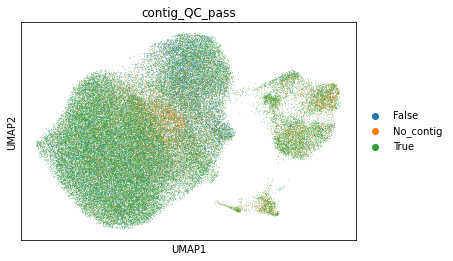

In [21]:
sc.pl.umap(bdata2, color = 'contig_QC_pass')

In [22]:
pd.crosstab(bdata2.obs['filter_contig'], bdata2.obs['contig_QC_pass'])

contig_QC_pass  False  No_contig   True
filter_contig                          
False            6986      10111  45992
True             7412          0      0

In [23]:
ddl.tl.find_clones(vdj)

Finding clones based on VDJ chains : 100%|████████████████████████████████████████████████████████| 462/462 [00:07<00:00, 63.65it/s]
Refining clone assignment based on VJ chain pairing : 100%|███████████████████████████████| 45992/45992 [00:00<00:00, 441672.48it/s]


In [24]:
if not os.path.exists('h5ddl'):
    os.makedirs('h5ddl')
vdj.write_h5('h5ddl/df.fil3_gex_bcells_no_CLL_vdj.h5ddl', compression = 'blosc:lz4')

In [25]:
ddl.tl.transfer(bdata2, vdj)

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/dandelion/tools/_tools.py:675: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [26]:
bdata2.write_h5ad('h5ad/df.fil3_gex_bcells_no_CLL_vdj.h5ad', compression = 'gzip')

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'clone_id' as categorical
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'locus_VDJ' as categorical
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical obje

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'constant_status_summary' as categorical


In [1]:
import os
import tools
import numpy as np
import pandas as pd
import scanpy as sc

sc.logging.print_header()

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.12.2 python-igraph==0.9.8 pynndescent==0.5.5


In [2]:
os.chdir('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal')

In [3]:
bdata2 = sc.read_h5ad('h5ad/df.fil3_gex_bcells_no_CLL_vdj.h5ad')
bdata2

AnnData object with n_obs × n_vars = 70501 × 318
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [4]:
# manually exlcude IgD+ cells in the putative ASC cluster
pd.crosstab(bdata2.obs['gmm_pct_b_scores'], bdata2.obs['isotype_summary'])

isotype_summary    IgA   IgD  IgD|IgM  IgE   IgG    IgM  Multi  No_contig  \
gmm_pct_b_scores                                                            
0                 3547  3102      256    1  3067  29512     51      22028   
1                 3251    43        0    1  1884    724      2       2481   

isotype_summary   unassigned  
gmm_pct_b_scores              
0                        547  
1                          4

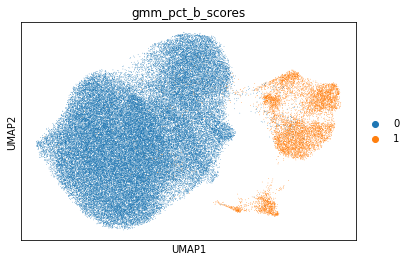

In [5]:
sc.pl.umap(bdata2, color = 'gmm_pct_b_scores')

In [6]:
non_pb = list(bdata2.obs[(bdata2.obs['gmm_pct_b_scores'] == 1) & (bdata2.obs['isotype_summary'] == 'IgD')].index)
len(non_pb)

43

/tmp/ipykernel_9745/2496348900.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  bdata2.obs['celltype_B'] = [b_dict[x] for x in bdata2.obs['gmm_pct_b_scores']]
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype_B' as categorical


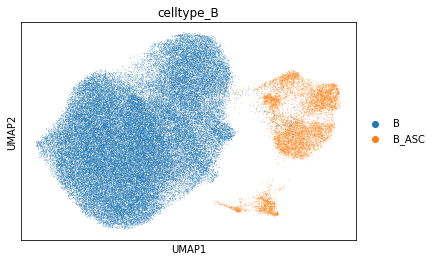

In [7]:
b_dict = {0:'B', 1:'B_ASC'}
bdata2.obs['celltype_B'] = [b_dict[x] for x in bdata2.obs['gmm_pct_b_scores']]
sc.pl.umap(bdata2, color = 'celltype_B')

In [8]:
bdata2.write_h5ad('h5ad/df.fil3_gex_bcells_no_CLL_vdj.h5ad', compression = 'gzip')

In [11]:
adata_raw = sc.read_h5ad('h5ad/df.fil3_gex_kt.h5ad')
adata_raw

AnnData object with n_obs × n_vars = 916806 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartm

In [12]:
adata_raw = adata_raw[adata_raw.obs_names.isin(bdata2.obs_names)].copy()
adata_raw.obs['celltype_B'] = pd.Series(bdata2.obs['celltype_B'])
adata_raw

/tmp/ipykernel_9745/629669440.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_raw.obs['celltype_B'] = pd.Series(bdata2.obs['celltype_B'])


AnnData object with n_obs × n_vars = 70501 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartme

In [13]:
# subset to bcells and ASC separately
bcell = adata_raw[adata_raw.obs['celltype_B'] == 'B'].copy()
ascs = adata_raw[adata_raw.obs['celltype_B'] == 'B_ASC'].copy()

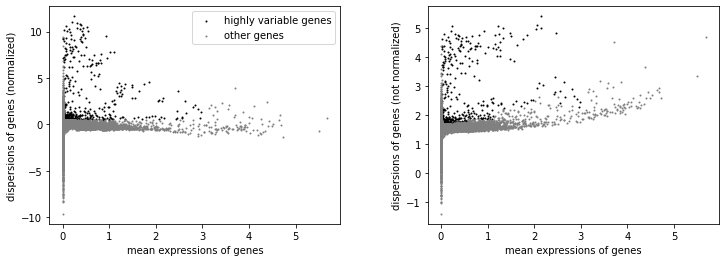

In [14]:
# find highly variable genes
sc.pp.highly_variable_genes(bcell, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(bcell)

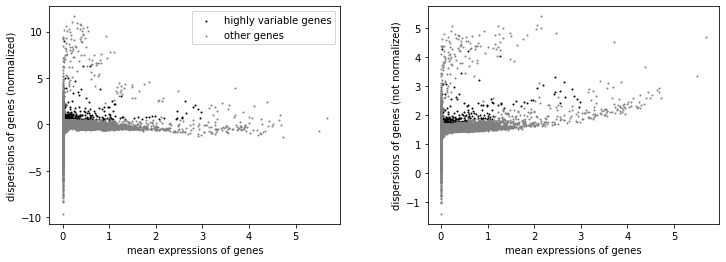

In [15]:
# remove vdj and light chain constant genes from highly variable genes, and also the viral reads
import re
for i in bcell.var.index:
    if re.search('^IG[HKL][VDJC]|VIRAL|^MTRNR', i):
        bcell.var.at[i, 'highly_variable'] = False
sc.pl.highly_variable_genes(bcell)

In [16]:
# transfer to .raw slot
bcell.raw = bcell

In [17]:
# Filter the rna genes to only those marked as highly-variable
bcell = bcell[:, bcell.var.highly_variable].copy()
bcell

AnnData object with n_obs × n_vars = 62111 × 378
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [18]:
import scvi

Global seed set to 0


In [20]:
scvi.model.SCVI.setup_anndata(
    bcell,
    layer="counts",
    batch_key = 'orig.ident',
    categorical_covariate_keys = ['individual_id'],
    continuous_covariate_keys=['nCount_RNA', 'percentMito']
)
model = scvi.model.SCVI(bcell)
model.train()
latent = model.get_latent_representation()
bcell.obsm["X_scVI"] = latent

INFO     Using batches from adata.obs["orig.ident"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 62111 cells, 378 vars, 119        
         batches, 1 labels, and 0 proteins. Also registered 1 extra categorical covariates   
         and 2 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/data/_anndata.py:728: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[alternate_column_key] = codes
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/data/_anndata.py:743: UserWarning: Category 31 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  warnings.warn(
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/data/_anndata.py:586: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, 

Epoch 1/129:   0%|                                                                                          | 0/129 [00:00<?, ?it/s]

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:433: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 129/129: 100%|███████████████████████████████████████████████████████████| 129/129 [11:03<00:00,  5.14s/it, loss=111, v_num=1]


/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [21]:
sc.pp.neighbors(bcell, use_rep="X_scVI")
sc.tl.umap(bcell, min_dist=0.3)

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scanpy/tools/_leiden.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[key_added] = pd.Categorical(


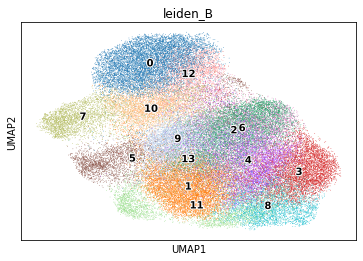

In [22]:
sc.tl.leiden(bcell, key_added = 'leiden_B')
sc.pl.umap(bcell, color = 'leiden_B', legend_loc = 'on data', legend_fontoutline = 2)

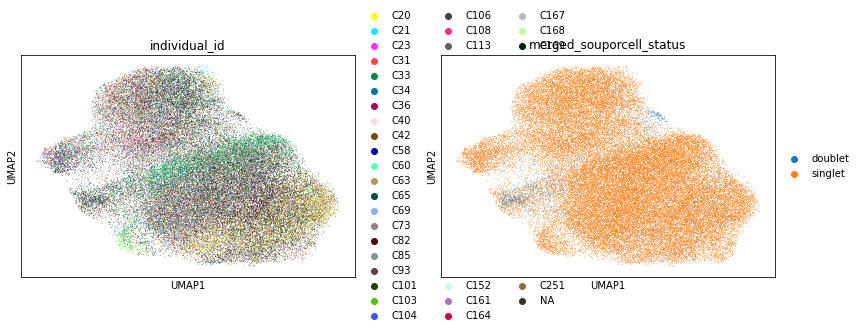

In [30]:
sc.pl.umap(bcell, color = ['individual_id','merged_souporcell_status'])

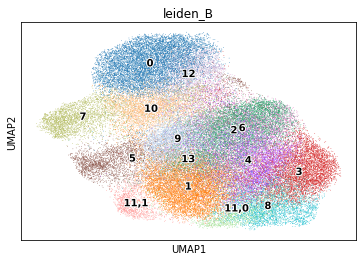

In [31]:
sc.tl.leiden(bcell, key_added = 'leiden_B', resolution = .2, restrict_to = ('leiden_B', ['11']))
sc.pl.umap(bcell, color = 'leiden_B', legend_loc = 'on data', legend_fontoutline = 2)

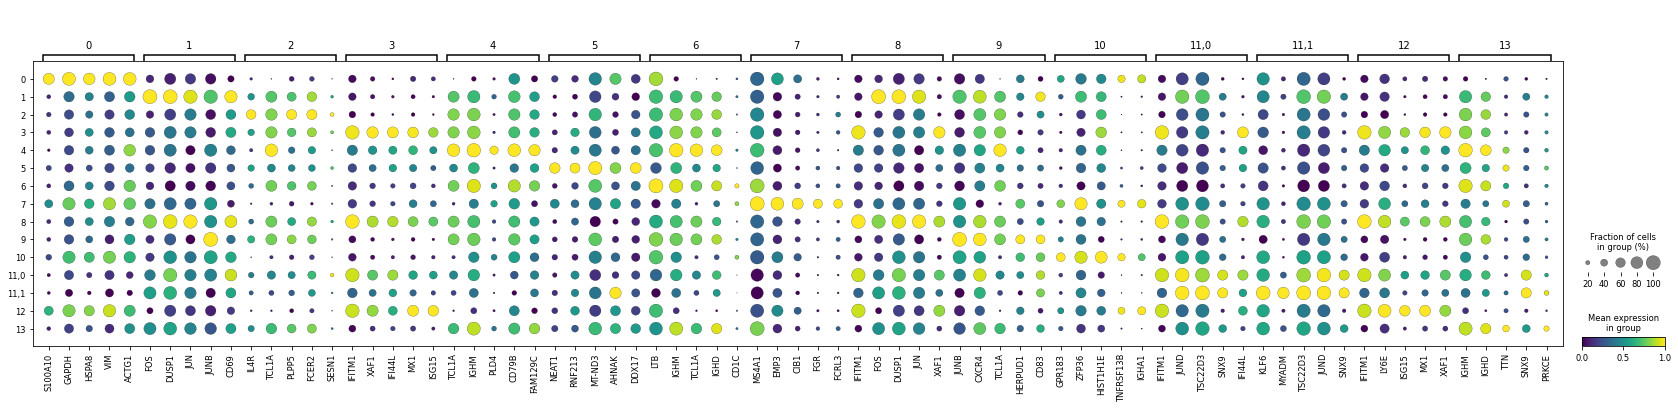

In [32]:
sc.tl.rank_genes_groups(bcell, groupby = 'leiden_B')
sc.pl.rank_genes_groups_dotplot(bcell, min_logfoldchange =1, n_genes=5, standard_scale = 'var',  color_map = 'viridis', dendrogram = False)

In [26]:
for i in ['Naive B cells_score', 'Non-switched memory B cells_score', 'Exhausted B cells_score', 'Switched memory B cells_score']:
    bcell.obs[i] = pd.Series(bdata2.obs[i])

/tmp/ipykernel_9745/1210491821.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  bcell.obs[i] = pd.Series(bdata2.obs[i])


In [27]:
def summarised_geneset_scores(self, genesets, groupby, figsize=(3, 4), cmap = 'viridis', col_cluster = True, row_cluster = True):
    import numpy as np
    import seaborn as sns
    # calculate average enrichment score
    list1 = list(set(self.obs[groupby]))
    subset = self.obs[[groupby] + [str(s) for s in genesets]]
    output = pd.DataFrame()
    for x in list1:
        subsetX = subset[subset[groupby] == x]
        outdict = {}
        for k in [str(s) for s in genesets]:
            out = {k:np.mean(subsetX[k])}
            outdict.update(out)
        output = output.append(outdict, ignore_index=True)
    output.index = list1
    output = output[[str(s) for s in genesets]]
    g = sns.clustermap(output.transpose(), standard_scale = 0, cmap=cmap, figsize=figsize, col_cluster = col_cluster, row_cluster = row_cluster)
    sc.pl.umap(self, color = [str(s) for s in genesets], size = 10, ncols = 2)
    print(g)

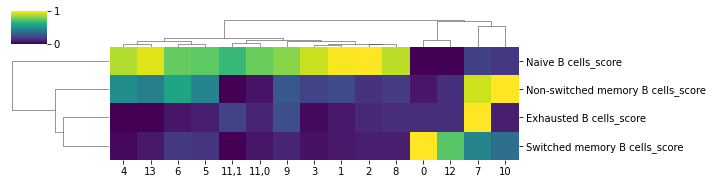

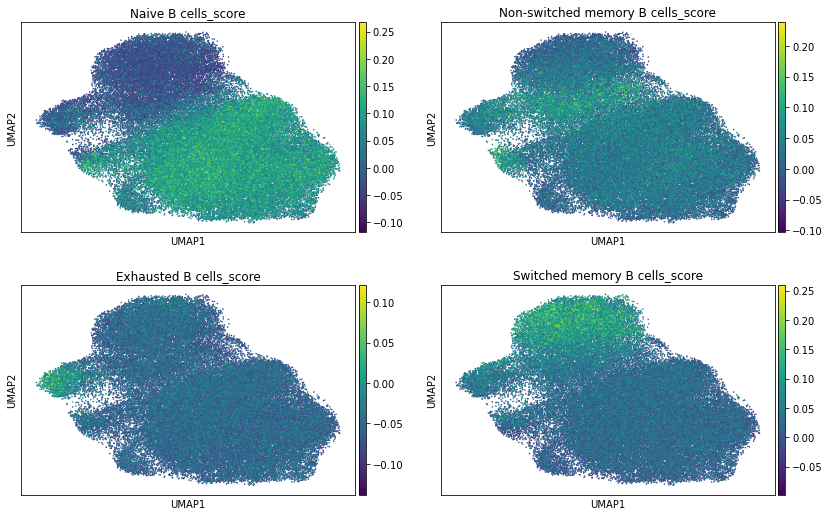

In [33]:
summarised_geneset_scores(bcell, ['Naive B cells_score', 
                                  'Non-switched memory B cells_score', 
                                  'Exhausted B cells_score', 
                                  'Switched memory B cells_score'], 
                          'leiden_B',
                          (10,2.5))

In [34]:
# read in the adt file
adt = sc.read_h5ad('h5ad/df.fil3_adt.h5ad')
badt = adt[adt.obs_names.isin(bcell.obs_names)].copy()
badt.obsm = bcell.obsm.copy()
badt.obs = bcell.obs.copy()
badt

AnnData object with n_obs × n_vars = 62111 × 137
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

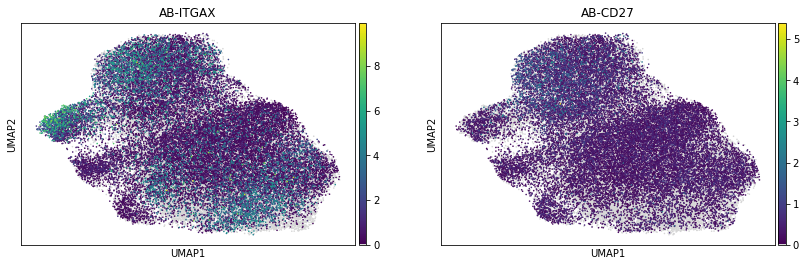

In [35]:
sc.pl.umap(badt, color = ['AB-ITGAX', 'AB-CD27'], color_map = tools.cmp(), size = 10)

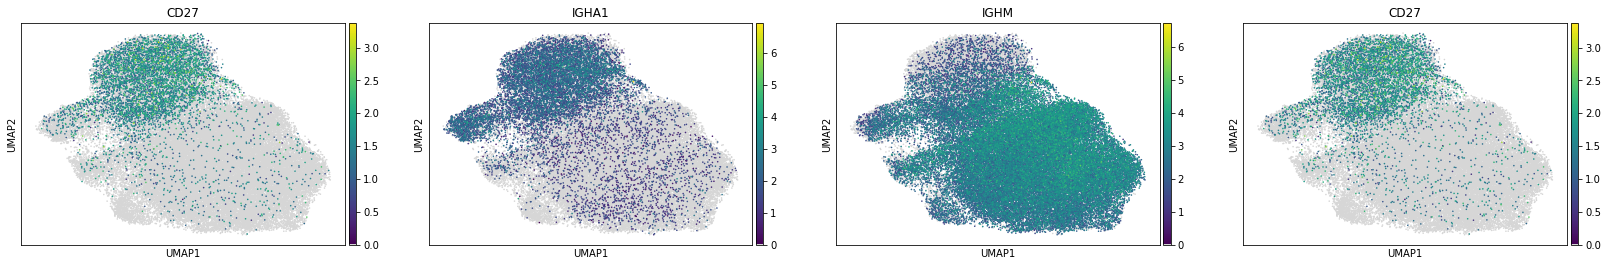

In [39]:
sc.pl.umap(bcell, color = ['CD27', 'IGHA1', 'IGHM', 'CD27'], color_map = tools.cmp(), size = 10)

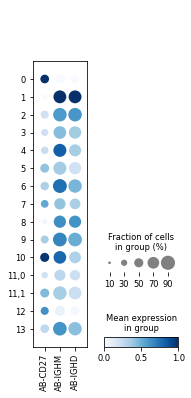

In [37]:
ax = sc.pl.dotplot(badt, ['AB-CD27', 'AB-IGHM','AB-IGHD'], groupby = 'leiden_B', color_map = 'Blues', standard_scale = 'var', return_fig = True)
ax.style(dot_edge_lw = 0, cmap = 'Blues')
ax.show()

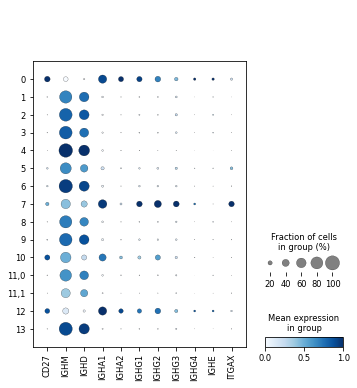

In [38]:
sc.pl.dotplot(bcell, ['CD27','IGHM','IGHD','IGHA1', 'IGHA2', 'IGHG1','IGHG2','IGHG3','IGHG4','IGHE','ITGAX'], groupby = 'leiden_B', color_map = 'Blues', standard_scale = 'var')

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype_B' as categorical


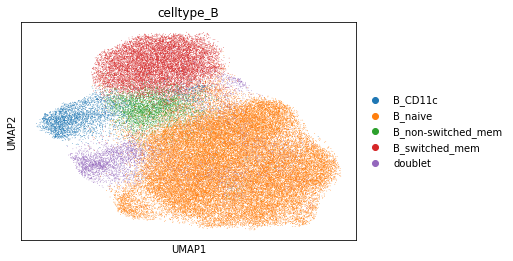

In [40]:
b_dict = {'0':'B_switched_mem',
'1':'B_naive',
'2':'B_naive',
'3':'B_naive',
'4':'B_naive',
'5':'doublet',
'6':'B_naive',
'7':'B_CD11c',
'8':'B_naive',
'9':'B_naive',
'10':'B_non-switched_mem',
'11,0':'B_naive',
'11,1':'B_naive',
'12':'B_switched_mem',
'13':'B_naive',}
bcell.obs['celltype_B'] = [b_dict[x] for x in bcell.obs['leiden_B']]
sc.pl.umap(bcell, color = 'celltype_B')

In [43]:
adata_raw.obs['celltype_B'] = adata_raw.obs['celltype_B'].astype('object')
adata_raw.obs['celltype_B'].update(bcell.obs['celltype_B'])

### subcluster naive

In [44]:
bnav = adata_raw[adata_raw.obs['celltype_B'] == 'B_naive'].copy()

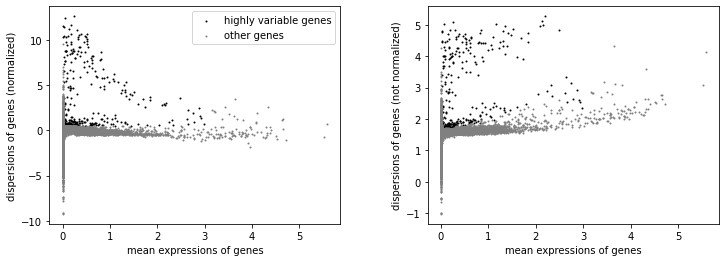

In [45]:
# find highly variable genes
sc.pp.highly_variable_genes(bnav, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(bnav)

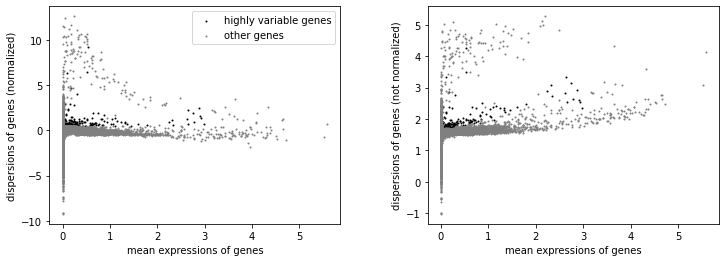

In [46]:
# remove vdj and light chain constant genes from highly variable genes, and also the viral reads
import re
for i in bnav.var.index:
    if re.search('^IG[HKL][VDJC]|VIRAL|^MTRNR', i):
        bnav.var.at[i, 'highly_variable'] = False
sc.pl.highly_variable_genes(bnav)

In [47]:
# transfer to .raw slot
bnav.raw = bnav

In [48]:
# Filter the rna genes to only those marked as highly-variable
bnav = bnav[:, bnav.var.highly_variable].copy()
bnav

AnnData object with n_obs × n_vars = 40337 × 267
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [49]:
scvi.model.SCVI.setup_anndata(
    bnav,
    layer="counts",
    batch_key = 'orig.ident',
    categorical_covariate_keys = ['individual_id'],
    continuous_covariate_keys=['nCount_RNA', 'percentMito']
)
model = scvi.model.SCVI(bnav)
model.train()
latent = model.get_latent_representation()
bnav.obsm["X_scVI"] = latent

INFO     Using batches from adata.obs["orig.ident"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 40337 cells, 267 vars, 118        
         batches, 1 labels, and 0 proteins. Also registered 1 extra categorical covariates   
         and 2 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/data/_anndata.py:728: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[alternate_column_key] = codes
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/data/_anndata.py:586: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[labels_key] = np.zeros(adata.shape[0], dtype=np.int64)
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/data/_anndata.py:315: UserWarning: Training will

Epoch 1/198:   0%|                                                                                          | 0/198 [00:00<?, ?it/s]

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:433: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 198/198: 100%|████████████████████████████████████████████████████████████| 198/198 [08:50<00:00,  2.68s/it, loss=75, v_num=1]


/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [50]:
sc.pp.neighbors(bnav, use_rep="X_scVI")
sc.tl.umap(bnav, min_dist=0.3)

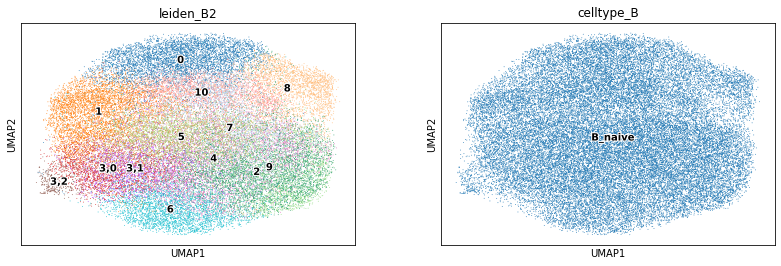

In [56]:
sc.tl.leiden(bnav, key_added = 'leiden_B2')
sc.tl.leiden(bnav, key_added = 'leiden_B2', restrict_to = ('leiden_B2', ['3']), resolution = .3)
# sc.tl.leiden(bnav, key_added = 'leiden_B2', restrict_to = ('leiden_B2', ['10']), resolution = .5)
sc.pl.umap(bnav, color = ['leiden_B2', 'celltype_B'], legend_loc = 'on data', legend_fontoutline = 2)

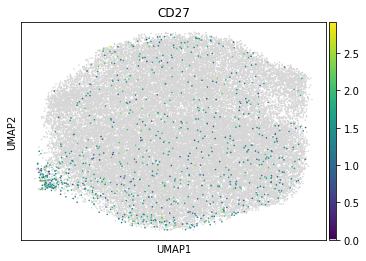

In [55]:
sc.pl.umap(bnav, color = ['CD27'], color_map = tools.cmp(), size = 10)

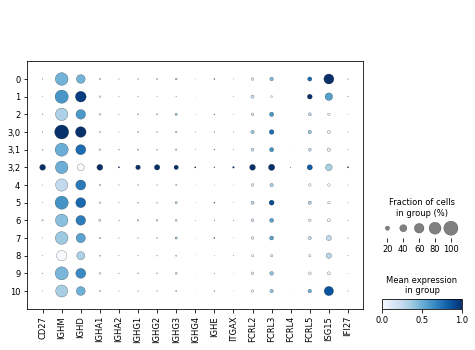

In [57]:
sc.pl.dotplot(bnav, ['CD27','IGHM','IGHD','IGHA1', 'IGHA2', 'IGHG1','IGHG2','IGHG3','IGHG4','IGHE','ITGAX', 'FCRL2','FCRL3','FCRL4','FCRL5', 'ISG15', 'IFI27'], groupby = 'leiden_B2', color_map = 'Blues', standard_scale = 'var')

/tmp/ipykernel_9745/1886728547.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  bnav.obs[i] = pd.Series(bdata2.obs[i])


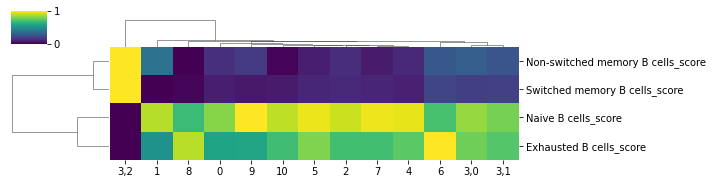

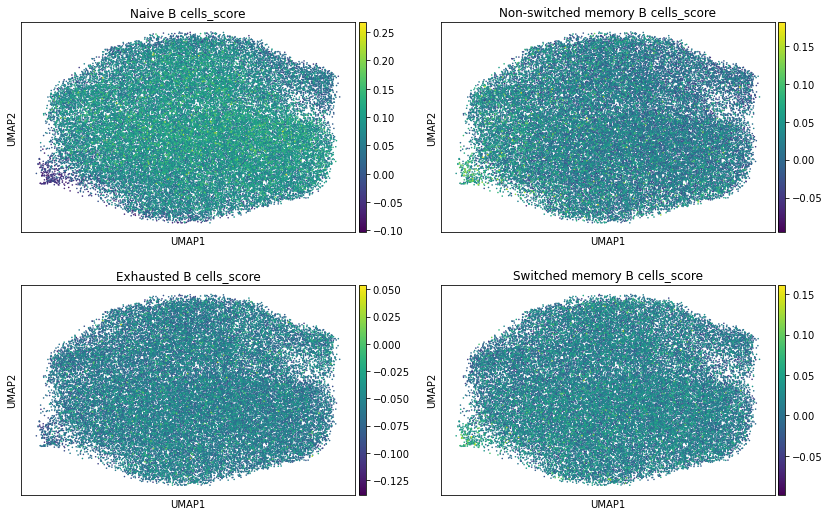

In [58]:
for i in ['Naive B cells_score', 'Non-switched memory B cells_score', 'Exhausted B cells_score', 'Switched memory B cells_score']:
    bnav.obs[i] = pd.Series(bdata2.obs[i])
summarised_geneset_scores(bnav, ['Naive B cells_score', 
                                  'Non-switched memory B cells_score', 
                                  'Exhausted B cells_score', 
                                  'Switched memory B cells_score'], 
                          'leiden_B2',
                          (10,2.5))

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype_B' as categorical


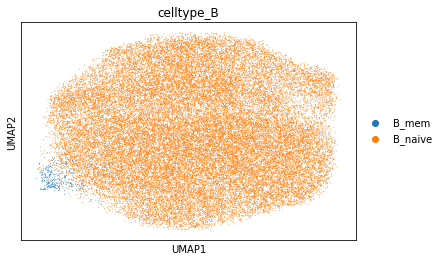

In [60]:
b_dict = {'0':'B_naive',
'1':'B_naive',
'2':'B_naive',
'3,0':'B_naive',
'3,1':'B_naive',
'3,2':'B_mem',
'4':'B_naive',
'5':'B_naive',
'6':'B_naive',
'7':'B_naive',
'8':'B_naive',
'9':'B_naive',
'10':'B_naive'}
bnav.obs['celltype_B'] = [b_dict[x] for x in bnav.obs['leiden_B2']]
sc.pl.umap(bnav, color = 'celltype_B')

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype_B' as categorical


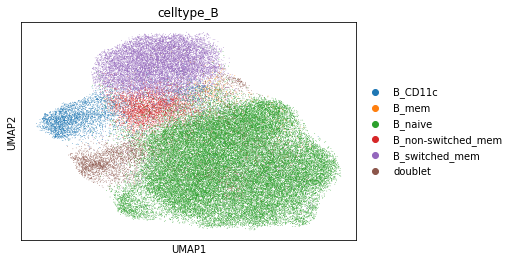

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype_B' as categorical


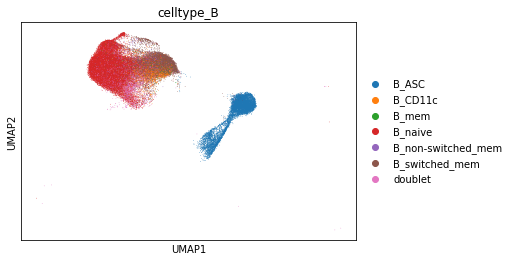

In [61]:
adata_raw.obs['celltype_B'] = adata_raw.obs['celltype_B'].astype('object')
bcell.obs['celltype_B'] = bcell.obs['celltype_B'].astype('object')
adata_raw.obs['celltype_B'].update(pd.Series(bnav.obs['celltype_B']))
bcell.obs['celltype_B'].update(pd.Series(bnav.obs['celltype_B']))
sc.pl.umap(bcell, color = 'celltype_B')
sc.pl.umap(adata_raw, color = 'celltype_B')

### subcluster naive

In [94]:
bmem = adata_raw[adata_raw.obs['celltype_B'].isin(['B_mem', 'B_non-switched_mem', 'B_switched_mem', 'B_CD11c'])].copy()

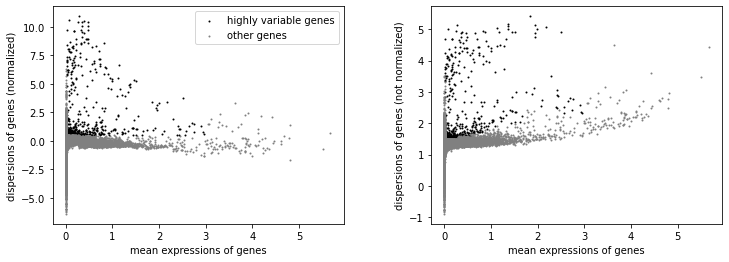

In [95]:
# find highly variable genes
sc.pp.highly_variable_genes(bmem, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(bmem)

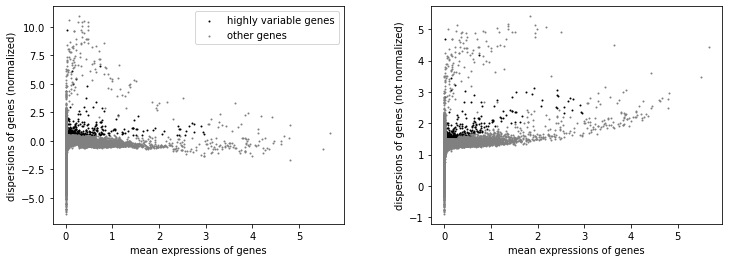

In [96]:
# remove vdj and light chain constant genes from highly variable genes, and also the viral reads
import re
for i in bmem.var.index:
    if re.search('^IG[HKL][VDJC]|VIRAL|^MTRNR', i):
        bmem.var.at[i, 'highly_variable'] = False
sc.pl.highly_variable_genes(bmem)

In [97]:
# transfer to .raw slot
bmem.raw = bmem

In [98]:
# Filter the rna genes to only those marked as highly-variable
bmem = bmem[:, bmem.var.highly_variable].copy()
bmem

AnnData object with n_obs × n_vars = 18365 × 603
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [99]:
scvi.model.SCVI.setup_anndata(
    bmem,
    layer="counts",
    batch_key = 'orig.ident',
    categorical_covariate_keys = ['individual_id'],
    continuous_covariate_keys=['nCount_RNA', 'percentMito']
)
model = scvi.model.SCVI(bmem)
model.train()
latent = model.get_latent_representation()
bmem.obsm["X_scVI"] = latent

INFO     Using batches from adata.obs["orig.ident"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 18365 cells, 603 vars, 119        
         batches, 1 labels, and 0 proteins. Also registered 1 extra categorical covariates   
         and 2 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/data/_anndata.py:728: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[alternate_column_key] = codes
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/data/_anndata.py:743: UserWarning: Category 31 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  warnings.warn(
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/data/_anndata.py:586: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, 

Epoch 1/400:   0%|                                                                                          | 0/400 [00:00<?, ?it/s]

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:433: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 400/400: 100%|███████████████████████████████████████████████████████████| 400/400 [08:16<00:00,  1.24s/it, loss=163, v_num=1]


/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [100]:
sc.pp.neighbors(bmem, use_rep="X_scVI")
sc.tl.umap(bmem, min_dist=0.3)

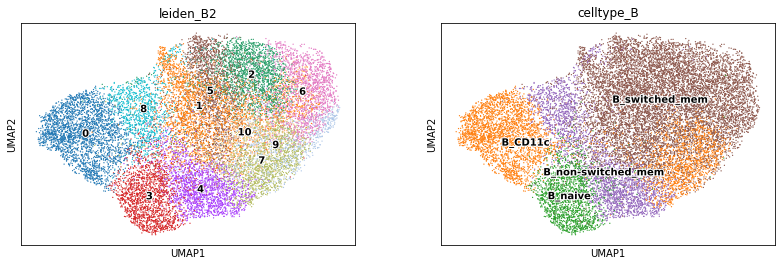

In [113]:
sc.tl.leiden(bmem, key_added = 'leiden_B2')
sc.pl.umap(bmem, color = ['leiden_B2', 'celltype_B'], legend_loc = 'on data', legend_fontoutline = 2)

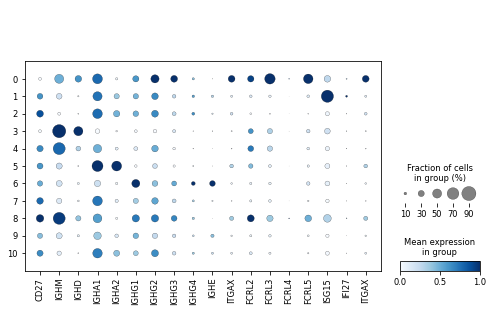

In [114]:
sc.pl.dotplot(bmem, ['CD27','IGHM','IGHD','IGHA1', 'IGHA2', 'IGHG1','IGHG2','IGHG3','IGHG4','IGHE','ITGAX', 'FCRL2','FCRL3','FCRL4','FCRL5', 'ISG15', 'IFI27', 'ITGAX'], groupby = 'leiden_B2', color_map = 'Blues', standard_scale = 'var')

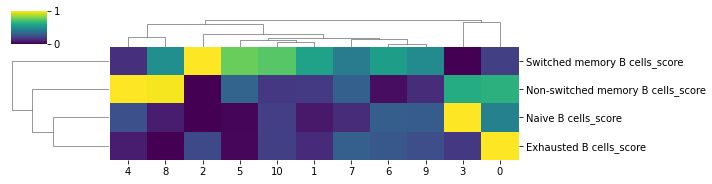

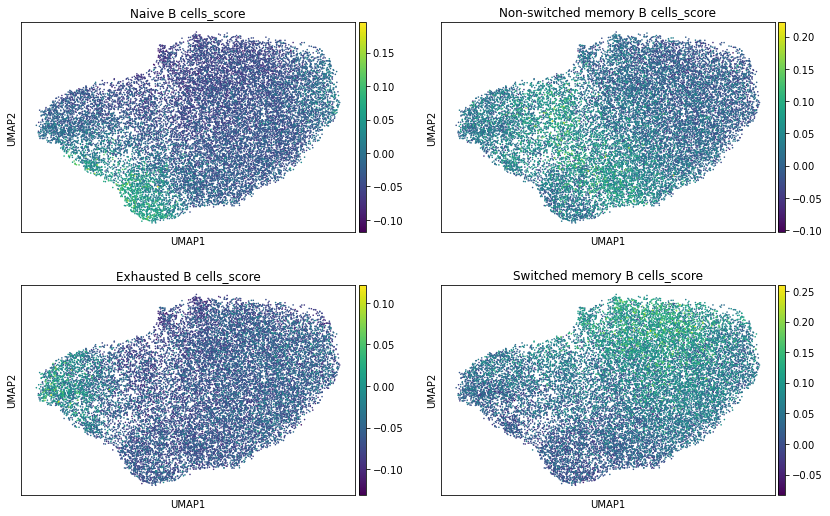

In [115]:
for i in ['Naive B cells_score', 'Non-switched memory B cells_score', 'Exhausted B cells_score', 'Switched memory B cells_score']:
    bmem.obs[i] = pd.Series(bdata2.obs[i])
summarised_geneset_scores(bmem, ['Naive B cells_score', 
                                  'Non-switched memory B cells_score', 
                                  'Exhausted B cells_score', 
                                  'Switched memory B cells_score'], 
                          'leiden_B2',
                          (10,2.5))

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype_B' as categorical


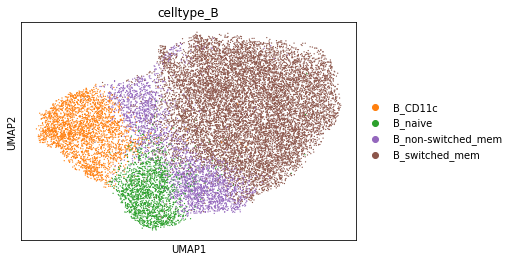

In [117]:
b_dict = {'0':'B_CD11c',
'1':'B_switched_mem',
'2':'B_switched_mem',
'3':'B_naive',
'4':'B_non-switched_mem',
'5':'B_switched_mem',
'6':'B_switched_mem',
'7':'B_switched_mem',
'8':'B_non-switched_mem',
'9':'B_switched_mem',
'10':'B_switched_mem',}
bmem.obs['celltype_B'] = [b_dict[x] for x in bmem.obs['leiden_B2']]
sc.pl.umap(bmem, color = 'celltype_B')

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype_B' as categorical


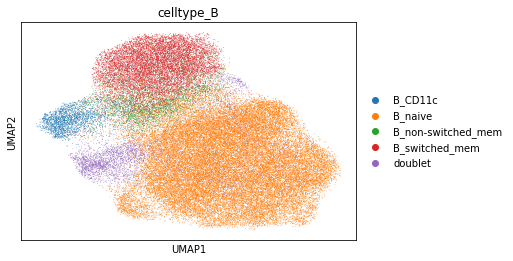

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype_B' as categorical


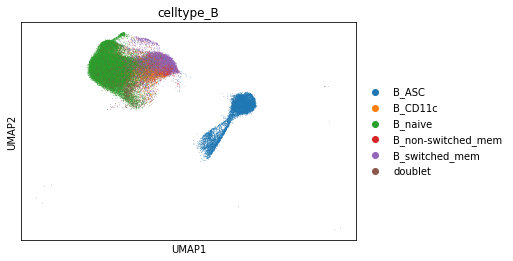

In [118]:
adata_raw.obs['celltype_B'] = adata_raw.obs['celltype_B'].astype('object')
bcell.obs['celltype_B'] = bcell.obs['celltype_B'].astype('object')
adata_raw.obs['celltype_B'].update(pd.Series(bmem.obs['celltype_B']))
bcell.obs['celltype_B'].update(pd.Series(bmem.obs['celltype_B']))
sc.pl.umap(bcell, color = 'celltype_B')
sc.pl.umap(adata_raw, color = 'celltype_B')

### analyse the ASCs

In [147]:
ascs = adata_raw[adata_raw.obs['celltype_B'].isin(['B_ASC'])].copy()
ascs

AnnData object with n_obs × n_vars = 8390 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartmen

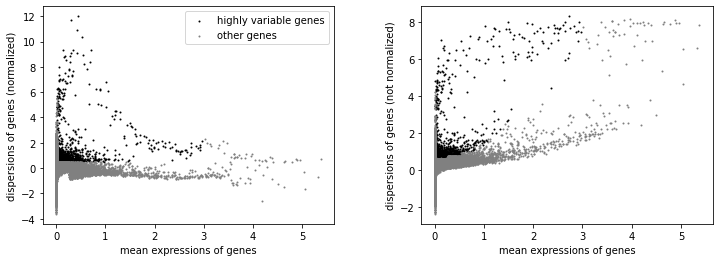

In [148]:
# find highly variable genes
sc.pp.highly_variable_genes(ascs, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(ascs)

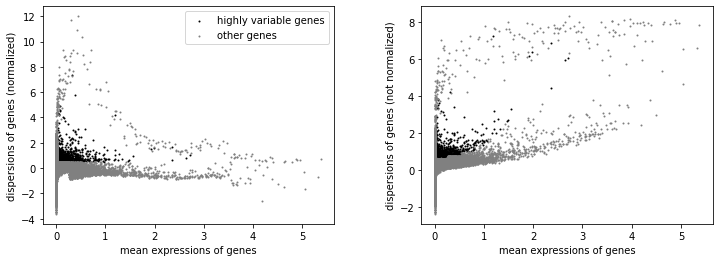

In [150]:
# remove vdj and light chain constant genes from highly variable genes, and also the viral reads
import re
for i in ascs.var.index:
    if re.search('^IG[HKL][VDJC]|VIRAL|^MTRNR', i):
        ascs.var.at[i, 'highly_variable'] = False
sc.pl.highly_variable_genes(ascs)

In [151]:
# transfer to .raw slot
ascs.raw = ascs

In [152]:
# Filter the rna genes to only those marked as highly-variable
ascs = ascs[:, ascs.var.highly_variable].copy()
ascs

AnnData object with n_obs × n_vars = 8390 × 2271
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'nCount_ADT_raw', 'nFeature_ADT_raw', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'exclude', 'centre', 'pool', 'tcrId', 'bcrId', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'seurat_clusters', 'RNA_sequencing_saturation', 'pool_factor', 'RNA_readsConfidentlyOnTranscriptome', 'RNA_readsConfidentlyOnGenome', 'RNA_readsOnGenome', 'RNA_Q30readsBarcode', 'RNA_Q30readsRead', 'RNA_Q30readsUmi', 'rna_snn_res.4', 'rna_snn_res.0.5', 'rna_snn_res.0.1', 'harmony_snn_res.4', 'yoshida_broad_predLabel_majorVote', 'harmony_snn_res.0.5', 'harmony_snn_res.0.1', 'cell_type_compartment

In [153]:
scvi.model.SCVI.setup_anndata(
    ascs,
    layer="counts",
    batch_key = 'orig.ident',
    categorical_covariate_keys = ['individual_id'],
    continuous_covariate_keys=['nCount_RNA', 'percentMito']
)
model = scvi.model.SCVI(ascs)
model.train()
latent = model.get_latent_representation()
ascs.obsm["X_scVI"] = latent

INFO     Using batches from adata.obs["orig.ident"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 8390 cells, 2271 vars, 119        
         batches, 1 labels, and 0 proteins. Also registered 1 extra categorical covariates   
         and 2 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/data/_anndata.py:728: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[alternate_column_key] = codes
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/data/_anndata.py:743: UserWarning: Category 31 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.
  warnings.warn(
/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/data/_anndata.py:586: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, 

Epoch 1/400:   0%|                                                                                          | 0/400 [00:00<?, ?it/s]

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:433: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 400/400: 100%|███████████████████████████████████████████████████████████| 400/400 [06:07<00:00,  1.09it/s, loss=936, v_num=1]


/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [154]:
sc.pp.neighbors(ascs, use_rep="X_scVI")
sc.tl.umap(ascs, min_dist=0.3)

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/scanpy/tools/_leiden.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[key_added] = pd.Categorical(


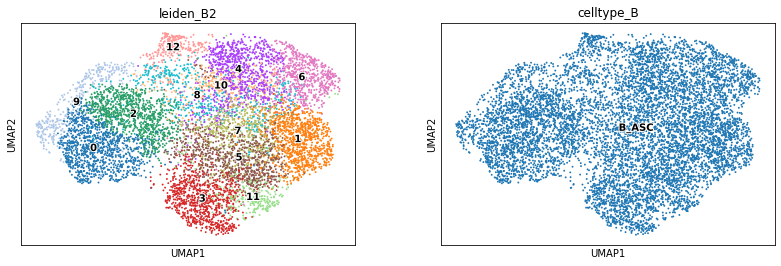

In [155]:
sc.tl.leiden(ascs, key_added = 'leiden_B2')
sc.pl.umap(ascs, color = ['leiden_B2', 'celltype_B'], legend_loc = 'on data', legend_fontoutline = 2)

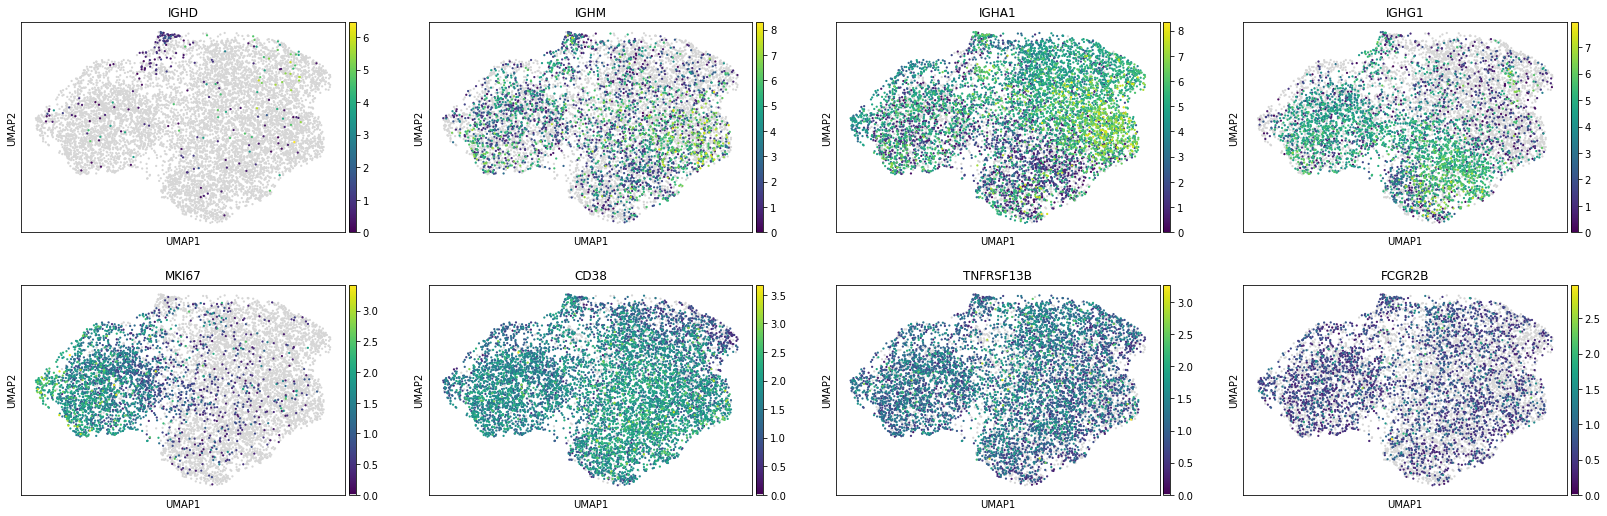

In [156]:
sc.pl.umap(ascs, color = ['IGHD', 'IGHM', 'IGHA1', 'IGHG1', 'MKI67', 'CD38', 'TNFRSF13B', 'FCGR2B'], color_map = tools.cmp(), size = 20)

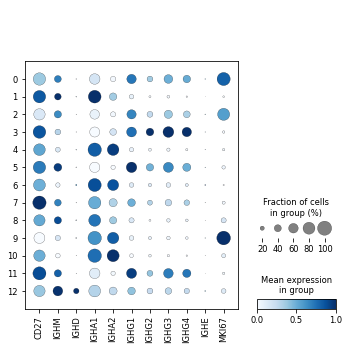

In [159]:
sc.pl.dotplot(ascs, ['CD27','IGHM','IGHD','IGHA1', 'IGHA2', 'IGHG1','IGHG2','IGHG3','IGHG4','IGHE', 'MKI67'], groupby = 'leiden_B2', color_map = 'Blues', standard_scale = 'var')

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype_B' as categorical


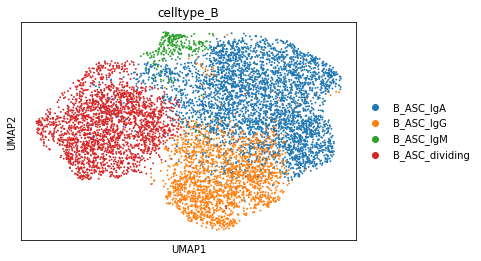

In [160]:
b_dict = {'0':'B_ASC_dividing',
'1':'B_ASC_IgA',
'2':'B_ASC_dividing',
'3':'B_ASC_IgG',
'4':'B_ASC_IgA',
'5':'B_ASC_IgG',
'6':'B_ASC_IgA',
'7':'B_ASC_IgA',
'8':'B_ASC_IgA',
'9':'B_ASC_dividing',
'10':'B_ASC_IgA',
'11':'B_ASC_IgG',
'12':'B_ASC_IgM',}
ascs.obs['celltype_B'] = [b_dict[x] for x in ascs.obs['leiden_B2']]
sc.pl.umap(ascs, color = 'celltype_B')

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype_B' as categorical


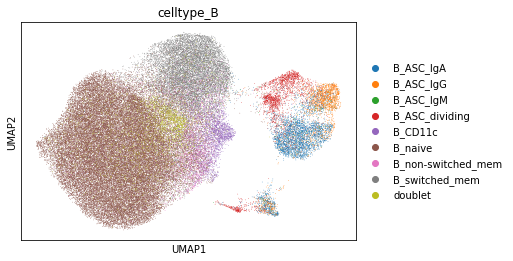

In [163]:
bdata2.obs['celltype_B'] = bdata2.obs['celltype_B'].astype('object')
bdata2.obs['celltype_B'].update(pd.Series(ascs.obs['celltype_B']))
bdata2.obs['celltype_B'].update(pd.Series(bcell.obs['celltype_B']))
sc.pl.umap(bdata2, color = 'celltype_B')

In [166]:
pd.crosstab(bdata2.obs['celltype_B'], bdata2.obs['isotype_summary'])

isotype_summary      IgA   IgD  IgD|IgM  IgE   IgG    IgM  Multi  No_contig  \
celltype_B                                                                    
B_ASC_IgA           2095    32        0    0   306    320      0       1017   
B_ASC_IgG            345     3        0    1   801    148      1        679   
B_ASC_IgM             55     1        0    0    38     29      1        141   
B_ASC_dividing       756     7        0    0   739    227      0        644   
B_CD11c              318   112        5    0   382    639      2       1148   
B_naive              129  2715      229    0   181  25395     38      12875   
B_non-switched_mem   301    43        3    0   179   1420      0        873   
B_switched_mem      2733    67        2    1  2273    787      8       4917   
doublet               66   165       17    0    52   1271      3       2215   

isotype_summary     unassigned  
celltype_B                      
B_ASC_IgA                    2  
B_ASC_IgG                    0  
B_ASC_IgM                    0  
B_ASC_dividing               2  
B_CD11c                     47  
B_naive                    184  
B_non-switched_mem          20  
B_switched_mem             272  
doublet                     24

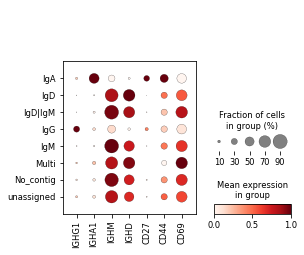

In [167]:
sc.pl.dotplot(bdata2[bdata2.obs['celltype_B'] == 'B_naive'], ['IGHG1', 'IGHA1', 'IGHM', 'IGHD', 'CD27', 'CD44', 'CD69'], 
              groupby = 'isotype_summary', 
              standard_scale = 'var')

In [173]:
bdata2.obs['celltype_B_corrected'] = bdata2.obs['celltype_B'].astype('object')

In [174]:
for i in bdata2.obs.index:
    iso = bdata2.obs.loc[i, 'isotype_summary']
    if bdata2.obs.loc[i, 'celltype_B_corrected'] == 'B_ASC_IgA':
        if iso in ['IgA', 'Multi', 'No_contig', 'unassigned']:
            continue
        if iso in ['IgE', 'IgD']:
            bdata2.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_other'
        if iso == 'IgM':
            bdata2.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_IgM'
        if iso == 'IgG':
            bdata2.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_IgG'
    if bdata2.obs.loc[i, 'celltype_B_corrected'] == 'B_ASC_IgG':
        if iso in ['IgG', 'Multi', 'No_contig', 'unassigned']:
            continue
        if iso in ['IgE', 'IgD']:
            bdata2.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_other'
        if iso == 'IgM':
            bdata2.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_IgM'
        if iso == 'IgA':
            bdata2.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_IgA'
    if bdata2.obs.loc[i, 'celltype_B_corrected'] == 'B_ASC_IgM':
        if iso in ['IgM', 'Multi', 'No_contig', 'unassigned']:
            continue
        if iso in ['IgE', 'IgD']:
            bdata2.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_other'
        if iso == 'IgG':
            bdata2.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_IgG'
        if iso == 'IgA':
            bdata2.obs.at[i, 'celltype_B_corrected'] = 'B_ASC_IgA'
    if bdata2.obs.loc[i, 'celltype_B_corrected'] == 'B_non-switched_mem':
        if iso in ['IgM', 'IgD', 'IgM|IgD', 'IgD|IgM', 'Multi', 'No_contig', 'unassigned']:
            pass
        else:
            bdata2.obs.at[i, 'celltype_B_corrected'] = 'B_switched_mem'
    if bdata2.obs.loc[i, 'celltype_B_corrected'] == 'B_switched_mem':
        if iso in ['IgG', 'IgA', 'IgE', 'Multi', 'No_contig', 'unassigned']:
            pass
        else:
            bdata2.obs.at[i, 'celltype_B_corrected'] = 'B_non-switched_mem'
    if bdata2.obs.loc[i, 'celltype_B_corrected'] == 'B_naive':
        if iso in ['IgM', 'IgD', 'IgM|IgD', 'IgD|IgM', 'Multi', 'No_contig', 'unassigned']:
            pass
        else:
            bdata2.obs.at[i, 'celltype_B_corrected'] = 'B_switched_mem'

In [175]:
pd.crosstab(bdata2.obs['celltype_B_corrected'], bdata2.obs['isotype_summary'])

isotype_summary        IgA   IgD  IgD|IgM  IgE   IgG    IgM  Multi  No_contig  \
celltype_B_corrected                                                            
B_ASC_IgA             2495     0        0    0     0      0      0       1017   
B_ASC_IgG                0     0        0    0  1145      0      1        679   
B_ASC_IgM                0     0        0    0     0    497      1        141   
B_ASC_dividing         756     7        0    0   739    227      0        644   
B_ASC_other              0    36        0    1     0      0      0          0   
B_CD11c                318   112        5    0   382    639      2       1148   
B_naive                  0  2715      229    0     0  25395     38      12875   
B_non-switched_mem       0   110        5    0     0   2207      0        873   
B_switched_mem        3163     0        0    1  2633      0      8       4917   
doublet                 66   165       17    0    52   1271      3       2215   

isotype_summary       unassigned  
celltype_B_corrected              
B_ASC_IgA                      2  
B_ASC_IgG                      0  
B_ASC_IgM                      0  
B_ASC_dividing                 2  
B_ASC_other                    0  
B_CD11c                       47  
B_naive                      184  
B_non-switched_mem            20  
B_switched_mem               272  
doublet                       24

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype_B_corrected' as categorical


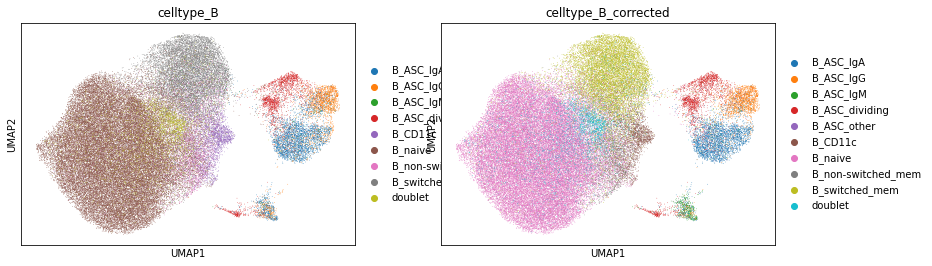

In [176]:
sc.pl.umap(bdata2, color = ['celltype_B', 'celltype_B_corrected'])

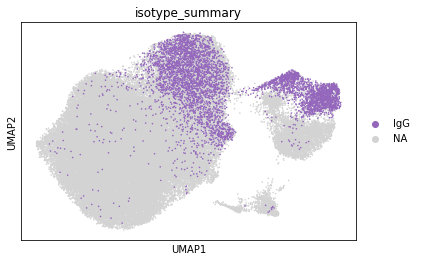

In [202]:
sc.pl.umap(bdata2, color = ['isotype_summary'], groups = ['IgG'], size = 10)

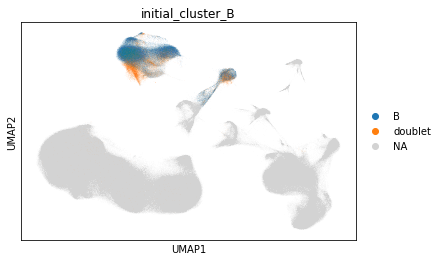

In [186]:
# update the raw object as well
adata_raw2 = sc.read_h5ad('h5ad/df.fil3_gex_kt.h5ad')
sc.pl.umap(adata_raw2, color = ['initial_cluster_B'])

/tmp/ipykernel_9745/1825183157.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_raw2.obs['celltype_B'] = pd.Series(adata_raw.obs['celltype_B'])
/tmp/ipykernel_9745/1825183157.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_raw2.obs['celltype_B_corrected'] = pd.Series(bdata2.obs['celltype_B_corrected'])


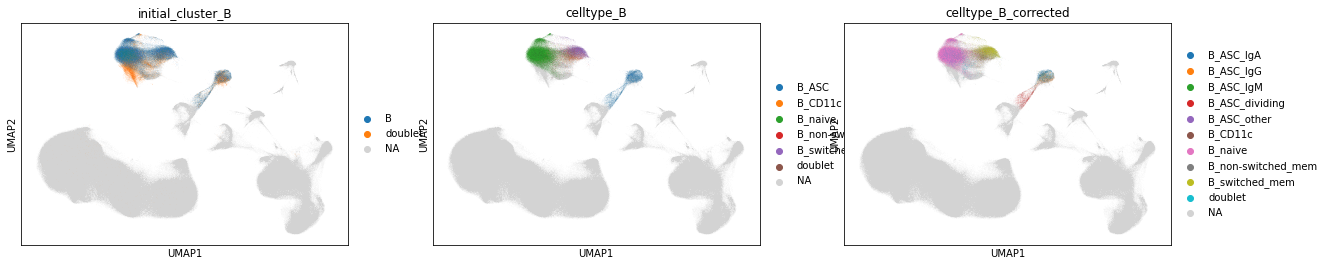

In [187]:
adata_raw2.obs['celltype_B'] = pd.Series(adata_raw.obs['celltype_B'])
adata_raw2.obs['celltype_B_corrected'] = pd.Series(bdata2.obs['celltype_B_corrected'])
sc.pl.umap(adata_raw2, color = ['initial_cluster_B', 'celltype_B', 'celltype_B_corrected'])

In [189]:
# fix discharge date
bdata2.obs['discharge_date'] = bdata2.obs['discharge_date'].astype('object')
bdata2.obs.at[bdata2.obs[bdata2.obs['patient_id'] == 'C65'].index, 'discharge_date'] = '10/06/2020'
adata_raw2.obs['discharge_date'] = adata_raw2.obs['discharge_date'].astype('object')
adata_raw2.obs.at[adata_raw2.obs[adata_raw2.obs['patient_id'] == 'C65'].index, 'discharge_date'] = '10/06/2020'

In [190]:
# save first
bdata2.write_h5ad('h5ad/df.fil3_gex_bcells_no_CLL_vdj.h5ad', compression = 'gzip')

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'discharge_date' as categorical


In [191]:
adata_raw2.write_h5ad('h5ad/df.fil3_gex_kt.h5ad', compression = 'gzip')

/nfs/team297/kt16/Softwares/conda/envs/scvi-env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'discharge_date' as categorical
